# Forward Model

### Define Model
> input: Phase and Absorbance

> parameters: Fresnel number (f) or E, Z, PV or Fresnel Factor (Fourier of PSF)

> prior param: absorbance factor ('abs_ratio'), 

> Fourier space param: Padding Mode: which can be 'constant', 'circular', 'replicate', 'reflect'


# or with famous cookie

/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


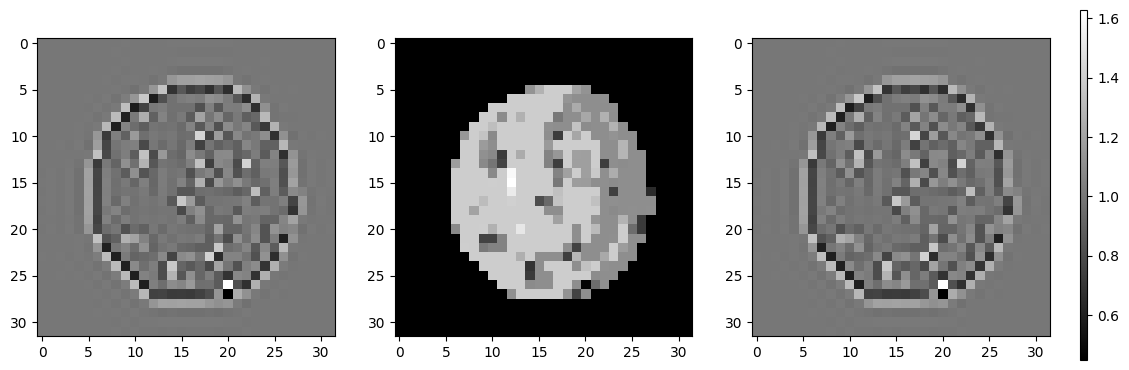

In [1]:
from libraries.available_experiments import *
import pylab as plt
image = plt.imread('/home/hailudaw/hailudaw/git_folders/CUQIpy/cuqi/data/cookie.png')
image = image[..., :3]
hx, hy = 32, 32
phase = resize_with_diff_interpolation(image[:, :, 0], (32, 32))
attenuation = resize_with_diff_interpolation(image[:, :, 1], (32, 32))
experiments = available_experiments(phase = phase, attenuation = attenuation, fresnel_number = 0.9, abs_ratio = 0.01)
prop = experiments.propagate_with_self()

images = [prop['phase'], prop['attenuation'], tensor_to_np(prop['image'])]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')

#add colorbar for all in one
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.005, 0.7])
fig.colorbar(axs[0].imshow(images[2], cmap='gray'), cax=cbar_ax)
# plt.title('Phase', 'Absorbance', 'Intensity')
plt.show()

# Starting to solve with Cuqipy

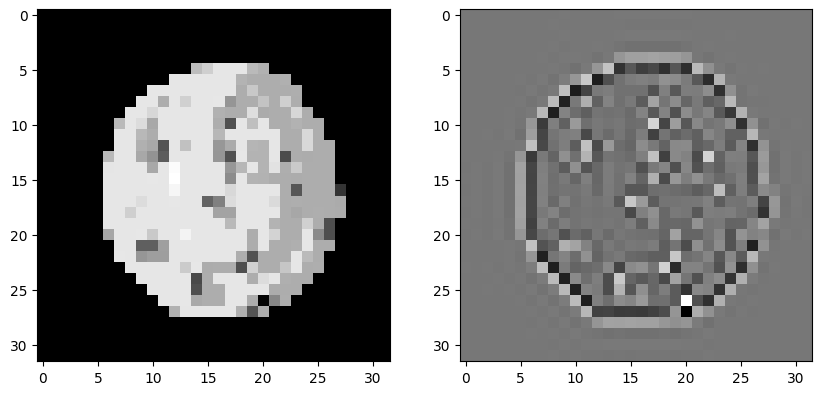

In [2]:
import cuqi
from cuqi.model import LinearModel, Model
from cuqi.distribution import Gaussian
from cuqi.problem import BayesianProblem
from cuqi.geometry import Geometry, MappedGeometry, StepExpansion, KLExpansion, KLExpansion_Full, CustomKL, Continuous1D, Continuous2D, Image2D
from cuqi.array import CUQIarray
import warnings

input_image = images[0]
range_image = images[2]
# range = tensor_to_np(A_prop['image'])
domain_geometry = Image2D(im_shape = input_image.shape)
range_geometry = Image2D(im_shape = range_image.shape)
phase_exact = CUQIarray(input_image, geometry=domain_geometry, is_par = False)
holo_exact = CUQIarray(range_image, geometry=range_geometry, is_par = False)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(phase_exact, cmap='gray')
axs[1].imshow(holo_exact, cmap='gray')
plt.show()


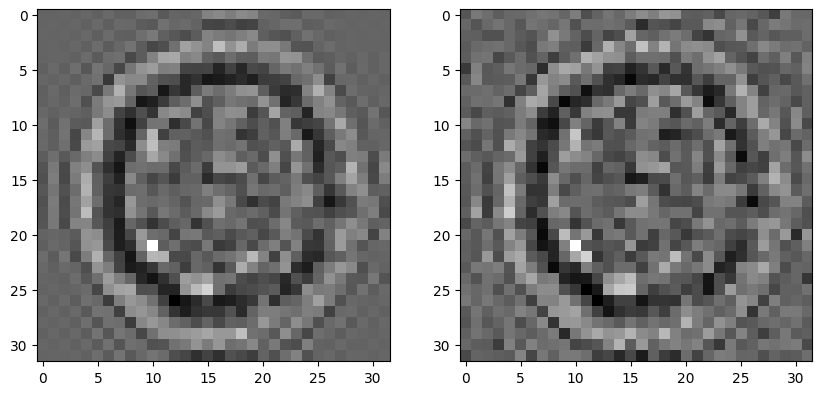

In [3]:
fresnel_number = 0.12584630069243095
def forward_fun(x, **kwargs):
    # m,n = x.__array__().shape
    phase = x
    attenuation = x
    # phase = x.__array__() if len(x.shape) == 1 else x
    kwargs['fresnel_number'] = fresnel_number
    kwargs['phase'] = tensor_to_np(pos_neg_image(phase,'relu_inverted'))
    kwargs['attenuation'] = np.zeros_like(phase) # kwargs['attenuation']
    propated = Fresnel_propagation(**kwargs)
    holo = np.array(tensor_to_np(propated.image))
    holo = np.concatenate([im for im in holo], axis = 1) if len(holo.shape) == 3 else holo
    # holo = CUQIarray(holo, geometry=Image2D(im_shape=holo.shape), is_par = False)
    return holo

y_exact = forward_fun(images[0])#, 
noise_leve = 0.1
y_data = tensor_to_np(torch_noise_gaussian(y_exact, mean = 0, std = noise_leve))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(y_exact, cmap='gray')
axs[1].imshow(y_data, cmap='gray')
plt.show()



In [4]:
model = cuqi.model.Model(forward_fun,range_geometry=range_geometry,domain_geometry=domain_geometry)
# visualize([together, range], cmap = 'gray', title = ['input', 'output'], show_or_plot='both', position ='middle right', plot_axis='diagonal')
# phase_attenuation = CUQIarray(together, geometry=Image2D(im_shape=(2, 512, 512)), is_par = False)

# What's my distribution
# 

/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/cuqi/distribution/_gaussian.py:365: RuntimeWarning: divide by zero encountered in log
  logdet = dim*np.log(var)
/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/cuqi/distribution/_gaussian.py:368: RuntimeWarning: divide by zero encountered in long_scalars
  prec = (1/var)*spa.identity(dim, format="csr")
/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/cuqi/distribution/_gaussian.py:369: RuntimeWarning: divide by zero encountered in long_scalars
  sqrtprec = np.sqrt(1/var)*spa.identity(dim, format="csr")


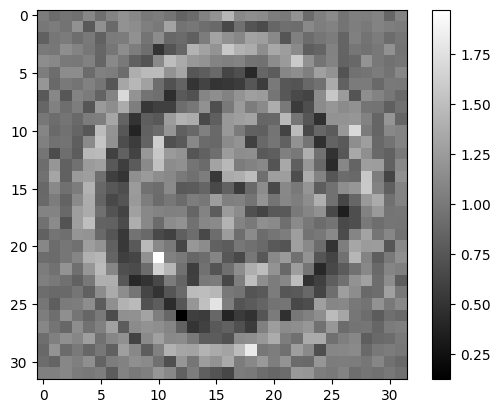

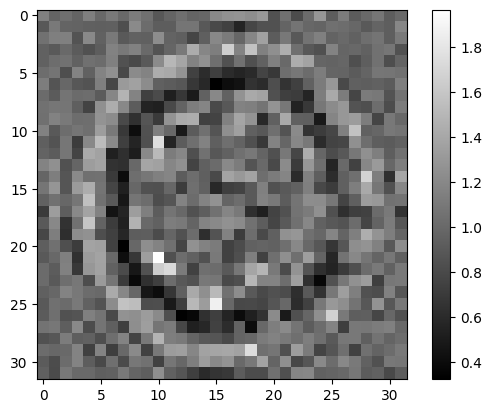

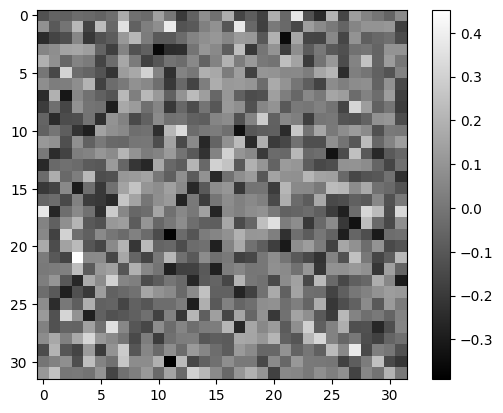

In [5]:
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

from cuqi.distribution import Gamma, LMRF, GMRF
# d = Gamma(1, 1e-4)
# s = Gamma(1, 1e-4)
# x = LMRF(0, 30, geometry = model.domain_geometry, name = 'x')
y = cuqi.distribution.Gaussian(mean=model, cov=0.01, geometry=range_geometry, name = 'y') #Geometry is not automatically inferred yet
data = y(x=images[0].flatten()).sample(1)
data.plot()
plt.colorbar()
plt.figure()
y_clear = cuqi.distribution.Gaussian(mean=model, cov=0, geometry=range_geometry, name = 'y') #Geometry is not automatically inferred yet
clear_data = y(x=images[0].flatten()).sample(1)
clear_data.plot()
plt.colorbar()
plt.figure()

(data-clear_data).plot()
plt.colorbar()

# x = cuqi.distribution.GMRF(
#     mean=np.zeros(model.domain_dim),
#     # physical_dim=2,
#     prec=10.00500, # Higher precision means more regularized solution.
#     order=2,  # Higher order mean more correlated structures. Can be 1 or 2.
#     bc_type="zero", # Boundary conditions for GMRF. Non-zero are experimental.
#     geometry=model.domain_geometry,
#     name = 'x',
# )

d = 38 #Gamma(1, 1e-4)
s = Gamma(1, 1e-4)
x = LMRF(0, 1/d, geometry=model.domain_geometry)

# x = cuqi.distribution.Gaussian(mean=model, cov=0.1, geometry=model.domain_geometry, name = 'x') #Geometry is not automatically inferred yet

# plot_samples = x.sample(3).plot()
# plt.colorbar(plot_samples[2])


In [6]:
np.linalg.norm(y_data - y_exact)

3.3039732

In [7]:
joint = cuqi.distribution.JointDistribution(x,y)
joint
hx, hy = 32, 32
y(x=np.random.randn(hx* hy)).sample(1).shape
y

CUQI Gaussian. Conditioning variables ['x'].

In [8]:
Posterior = joint(y = data)
Posterior.enable_FD(epsilon=1e-9)

In [9]:
phase_exact.to_numpy().shape

(32, 32)

In [11]:
logpdf = Posterior.logpdf(x = phase_exact.to_numpy().flatten())#np.random.randn(256*256))
logpdf

array([2218.16739485])

In [12]:
# sampler = cuqi.sampler.pCN(target = Posterior, x0= images[2])
# new_sampler = cuqi.experimental.mcmc.MALA(target = Posterior, initial_point = tensor_to_np(torch_noise_gaussian(images[1],0, 1)).flatten(), scale = 1e-3)
# new_sampler = cuqi.experimental.mcmc.MH(target = Posterior, initial_point = tensor_to_np(torch_noise_gaussian(images[1],0, 1)).flatten(), scale = 1e-3)
# sampler = cuqi.sampler.pCN(target = Posterior, x0= images[2])
new_sampler = cuqi.experimental.mcmc.MH(target = Posterior, initial_point =tensor_to_np(torch_noise_gaussian(images[1],0, 1)).flatten())

In [14]:
new_sampler.warmup(30000)
result = new_sampler.get_samples()

Warmup: 100%|██████████| 30000/30000 [04:07<00:00, 121.34it/s]


Selecting 5 randomly chosen variables


/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/beegfs/desy/user/hailudaw/anacon/envs/tor/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a

array([[<AxesSubplot: title={'center': 'x4'}>,
        <AxesSubplot: title={'center': 'x4'}>],
       [<AxesSubplot: title={'center': 'x389'}>,
        <AxesSubplot: title={'center': 'x389'}>],
       [<AxesSubplot: title={'center': 'x676'}>,
        <AxesSubplot: title={'center': 'x676'}>],
       [<AxesSubplot: title={'center': 'x829'}>,
        <AxesSubplot: title={'center': 'x829'}>],
       [<AxesSubplot: title={'center': 'x879'}>,
        <AxesSubplot: title={'center': 'x879'}>]], dtype=object)

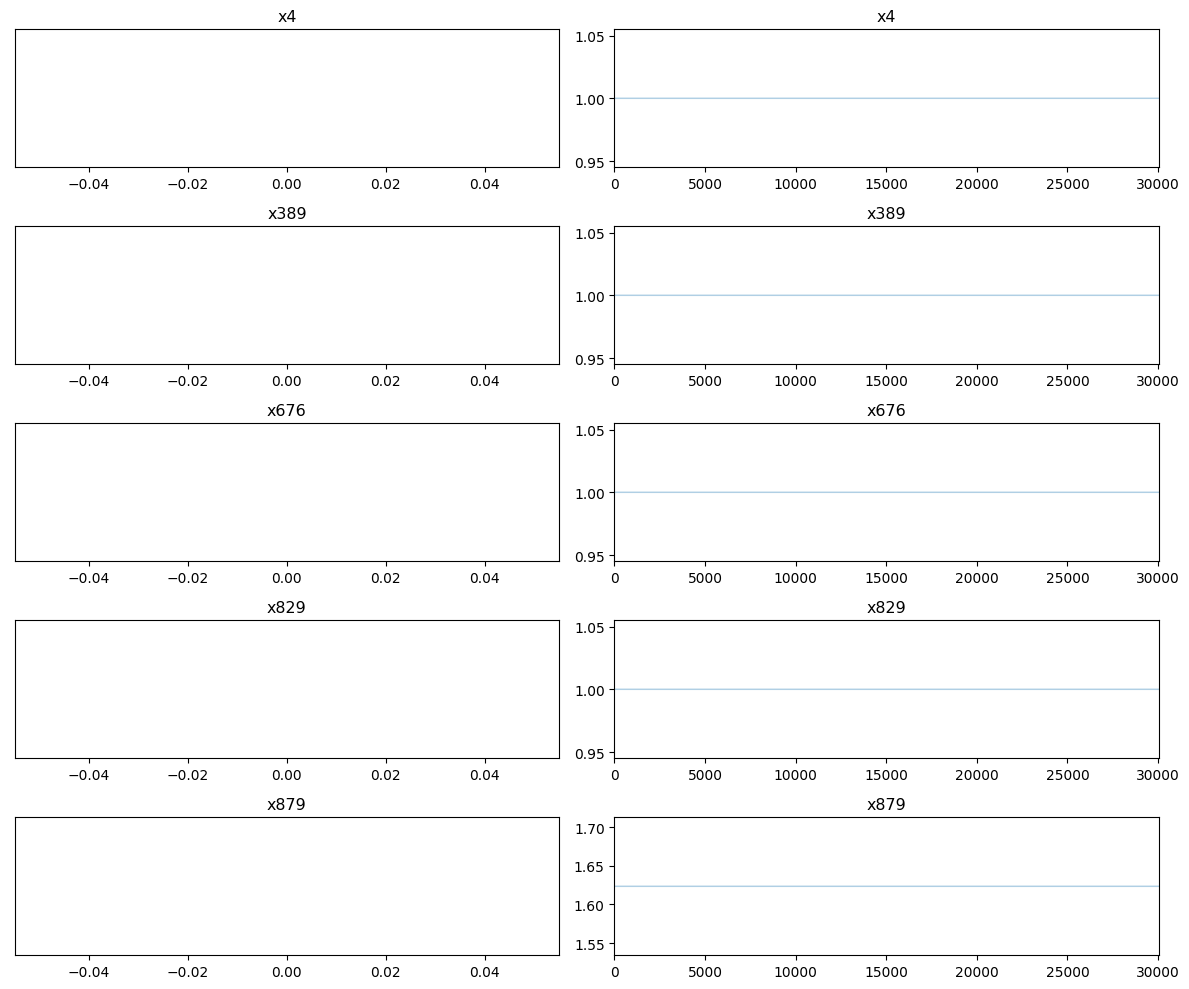

In [15]:
result.plot_trace()

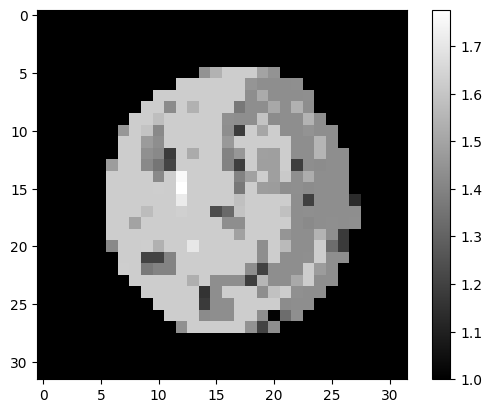

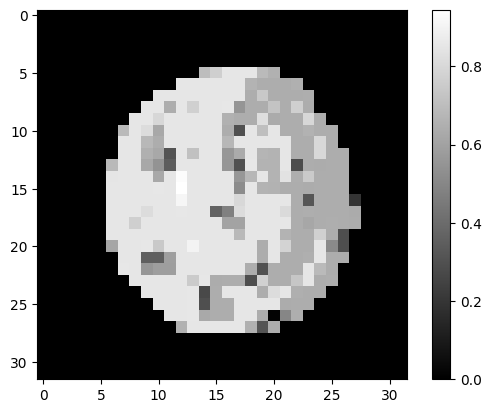

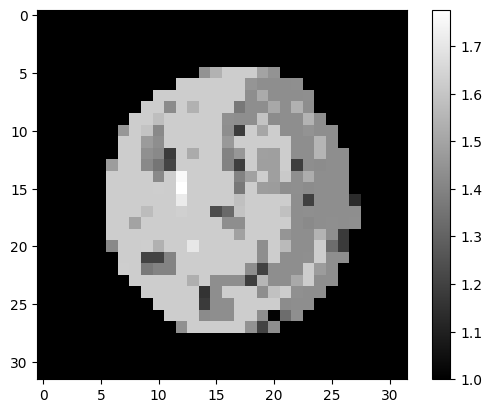

In [16]:
result.plot([1])
plt.colorbar(result.plot([1])[0])
plt.figure()
plt.imshow(phase_exact, cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(tensor_to_np(torch_noise_gaussian(images[1],0, 1)), cmap='gray')
plt.colorbar()

In [17]:
result.compute_ess()

array([30030., 30030., 30030., ..., 30030., 30030., 30030.])

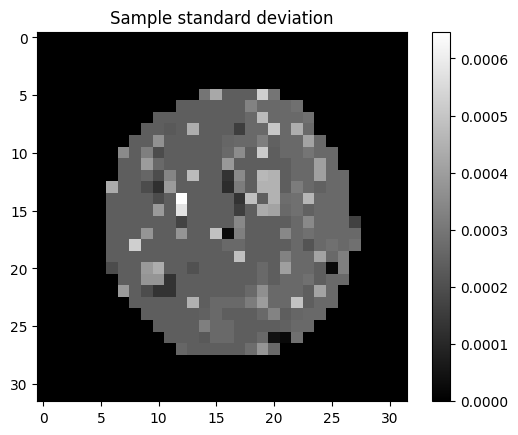

In [18]:

figage = result.plot_std()
plt.colorbar(figage[0])